# Fit an arctangent velocity model

This is a demo showing how FRApy can be used to fit a simple velocity model. In this case an arctangent model. We do not fit the velocity dispersion, but we can use our model to calculate how much of the measured velocity dispersion come from beam smearing (i.e. purelly observational hazards and not from the turbulence of the gas in the galaxy)

The data being fit is a very interesting and very magnified galaxy at z=0.721, nicknamed the dragon, for obvious visual reasons:

![A370](img/a370.png)


More information about this galaxy and its kinematic analysis was published in __[Patricio et al. 2018](https://academic.oup.com/mnras/advance-article/doi/10.1093/mnras/sty555/4919636?guestAccessKey=68f01c9f-8a00-4d7a-b398-c74a3a0c2c9a)__

In [1]:
# For prettiness
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt

# Temporary work-around
import sys
frapy_path = '../'
sys.path.append(frapy_path)
sys.path

# Import FRApy
from frapy import Observation,Velocity_Arctangent,fit_model,make_input_parameters,Output

## Observations

Let's start by loading our observations (i.e. data), in this case, a metallicity map of a galaxy at z=0.611 observed with MUSE.

We'll use a *Observation* class to do this

In [2]:
obs = Observation(z=0.725,
                  data_path='Demo_data/A370_velocity.fits',
                  unc_path='Demo_data/A370_velocity_uncertainty.fits',
                  seeing = 0.7/0.2)

In [3]:
obs.info()

Data: Demo_data/A370_velocity.fits
Redshift: 0.725
Seeing (in pixels): 3.4999999999999996
Uncertainty: Demo_data/A370_velocity_uncertainty.fits


<IPython.core.display.Javascript object>


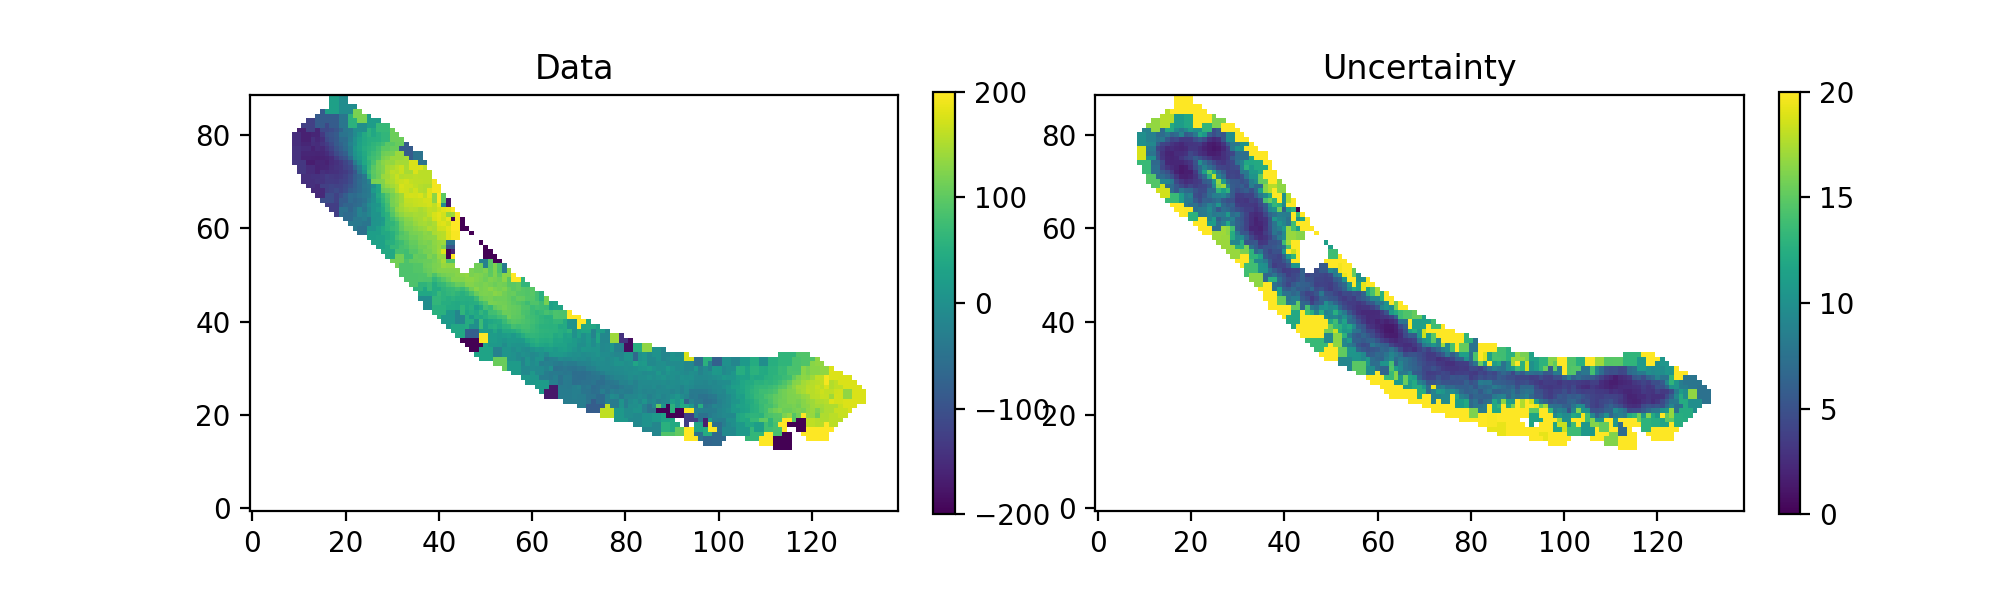

In [4]:
obs.plot(data_lim=(-200,200),unc_lim=(0,20))

Now let's create a velocity model, in this case the arctangent model.

In [7]:
model = Velocity_Arctangent(zlens=0.32,
                            dfx_path='Demo_data/A370_dplx.fits',
                            dfy_path='Demo_data/A370_dply.fits')

In [8]:
model.lensing_info()

Lens redshift: 0.3200
Deflection map (x): Demo_data/A370_dplx.fits
dDflection map (y): Demo_data/A370_dply.fits


We can also check what are the model parameters

In [9]:
model_parameters = model.model_parameters(verbose=True)
print(model_parameters)

cx: x position of the centre (in pixels)
cy: y position of the centre (in pixels)
q: axis ratio (a/b)
pa: position angle (in degrees)
v_t : terminal velocity
r_t: transition velocity
['cx', 'cy', 'q', 'pa', 'v_t', 'r_t']


Using the 'make_displacement_maps_for_object' for our observations (passing the observation object we created into this method), we fix this problem, by producing displacement maps at the correct redshift and aligned with our data, ready to be used.

In [11]:
model.create_projection_maps(obs,correct_z=False)

If we now try again to obtain a distance map, it should work

<IPython.core.display.Javascript object>


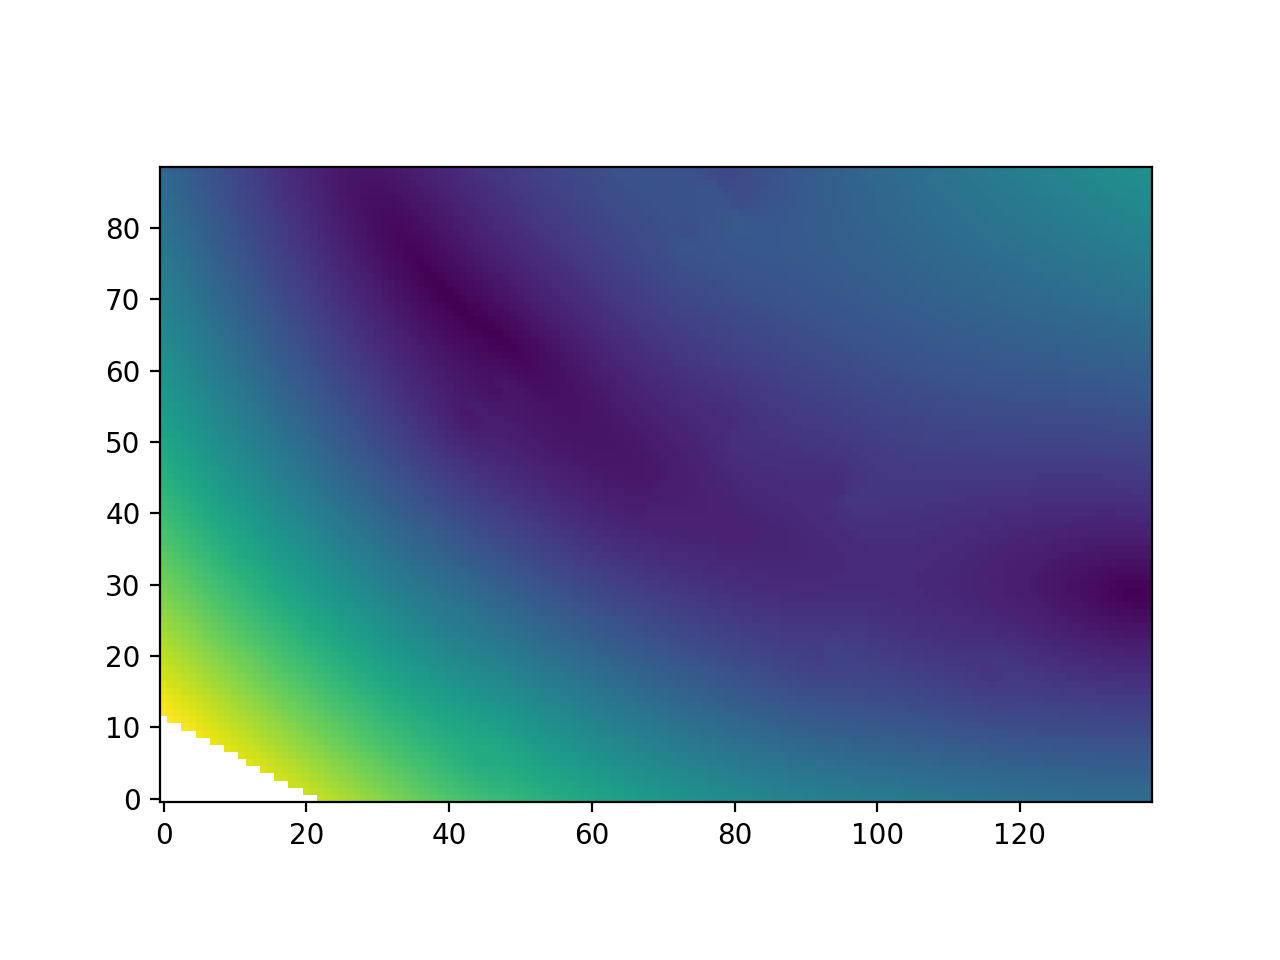

In [12]:
model.cx = 40
model.cy = 70
model.q = 0.9
dist = model.make_distance_map()
plt.figure()
plt.imshow(dist,origin='lower')

<IPython.core.display.Javascript object>


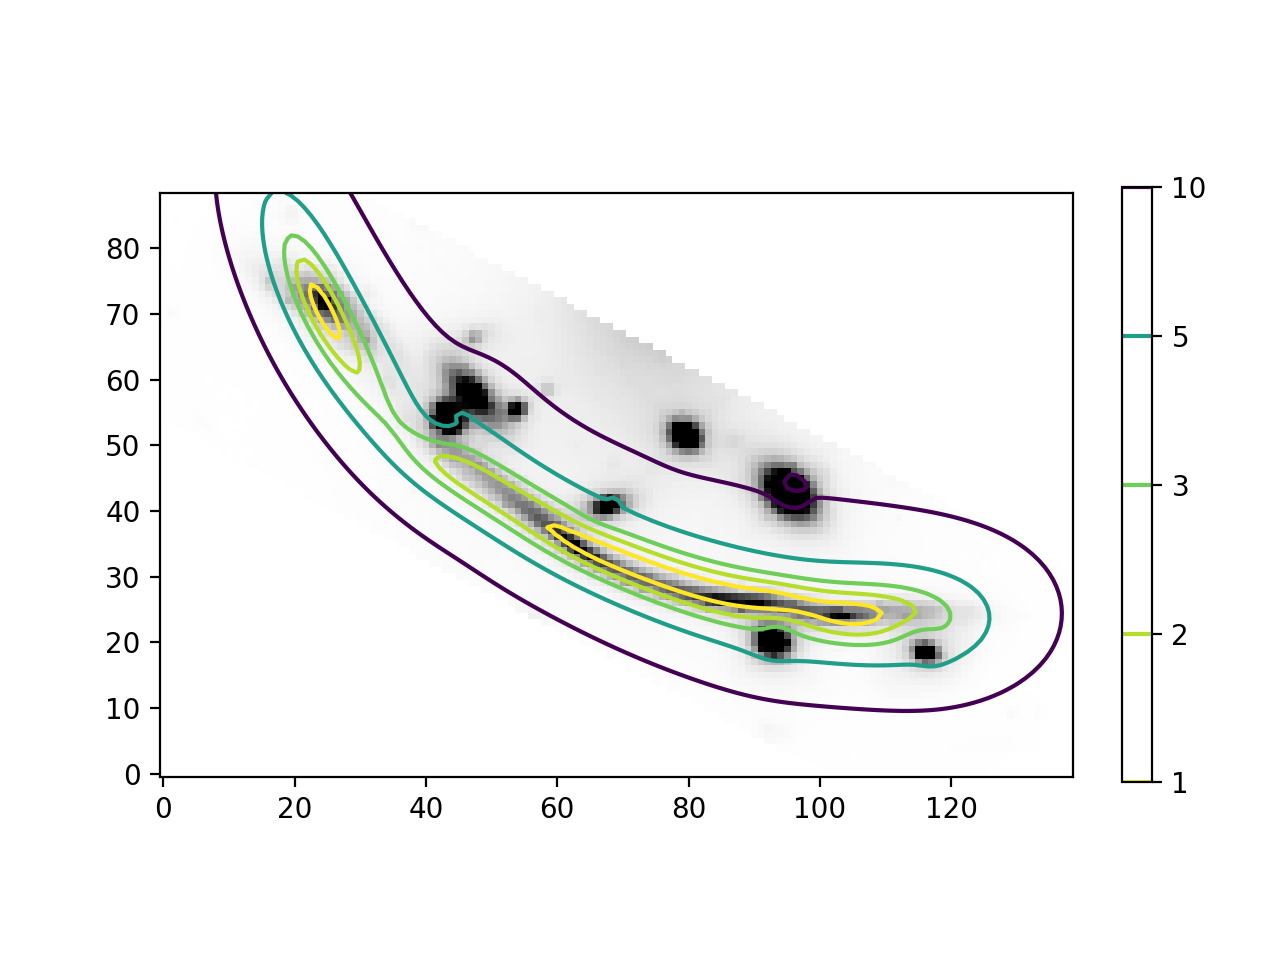

In [27]:
from reproject import reproject_exact
hst,_ = reproject_exact('/Users/vera/MetMaps/Data/HST/A370_F160w.fits',obs.header)

model.cx = 24
model.cy = 70
model.q = 0.78
model.pa = 112
dist = model.make_distance_map()
#q 0.7842$^{+0.0081}_{-0.0073}$
#cy 69.9764$^{+0.3385}_{-0.3184}$
#pa 112.2708$^{+0.1334}_{-0.1300}$
#cx 24.0016$^{+0.3430}_{-0.3371}$

plt.figure()
plt.imshow(hst,origin='lower',vmax=0.15,cmap='Greys')
cax = plt.contour(dist,origin='lower',levels=[1,2,3,5,10],cmap='viridis_r')
plt.colorbar(cax,fraction=0.03)

<IPython.core.display.Javascript object>


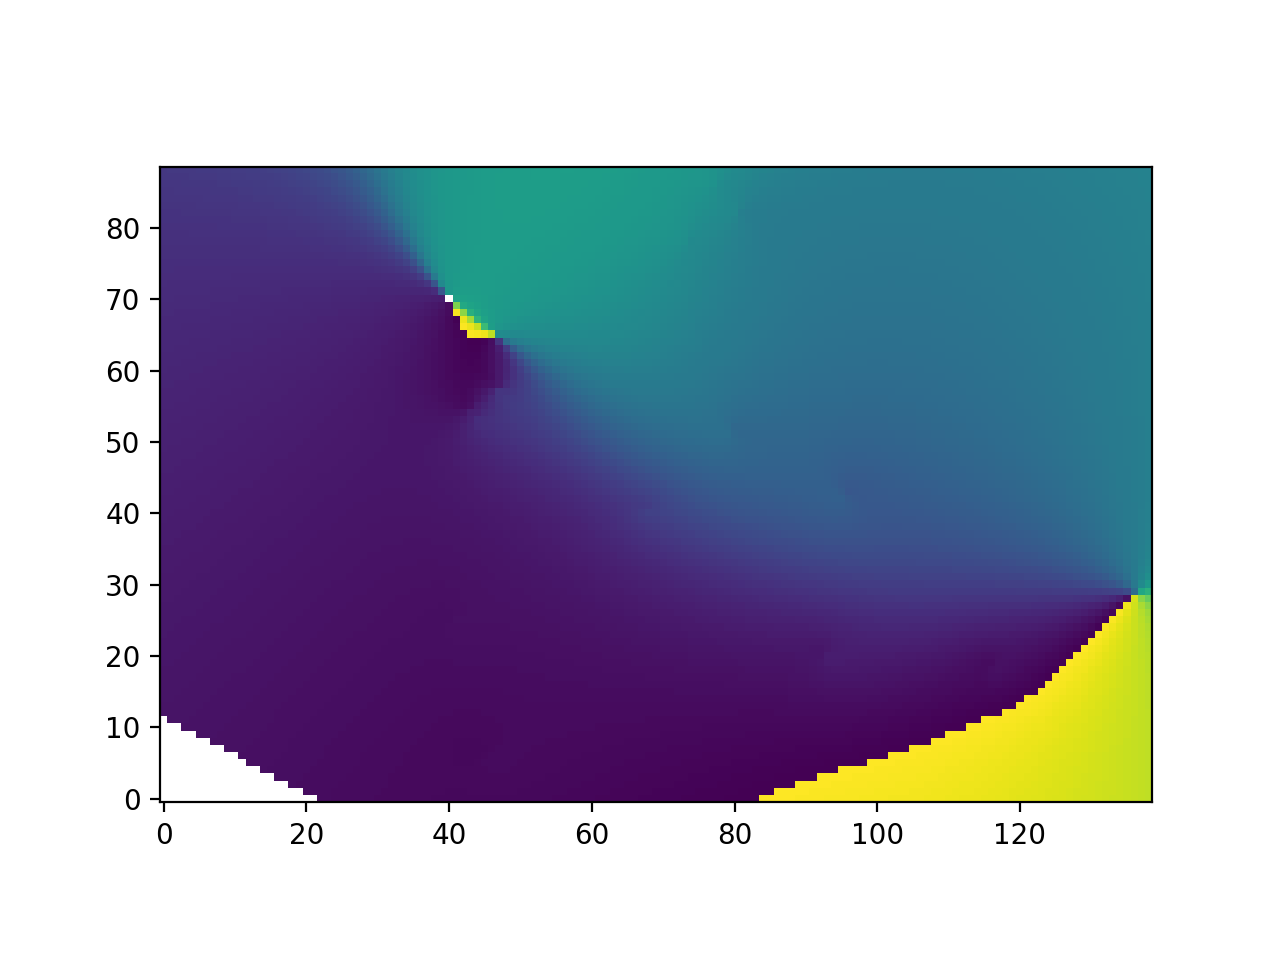

In [17]:
ang = model.make_azimuthal_map()
plt.figure()
plt.imshow(ang,origin='lower')

We can also produce the actual model we are interested in (most of the times we won't need the distance map, this is just an intermediate step common to all models)

<IPython.core.display.Javascript object>


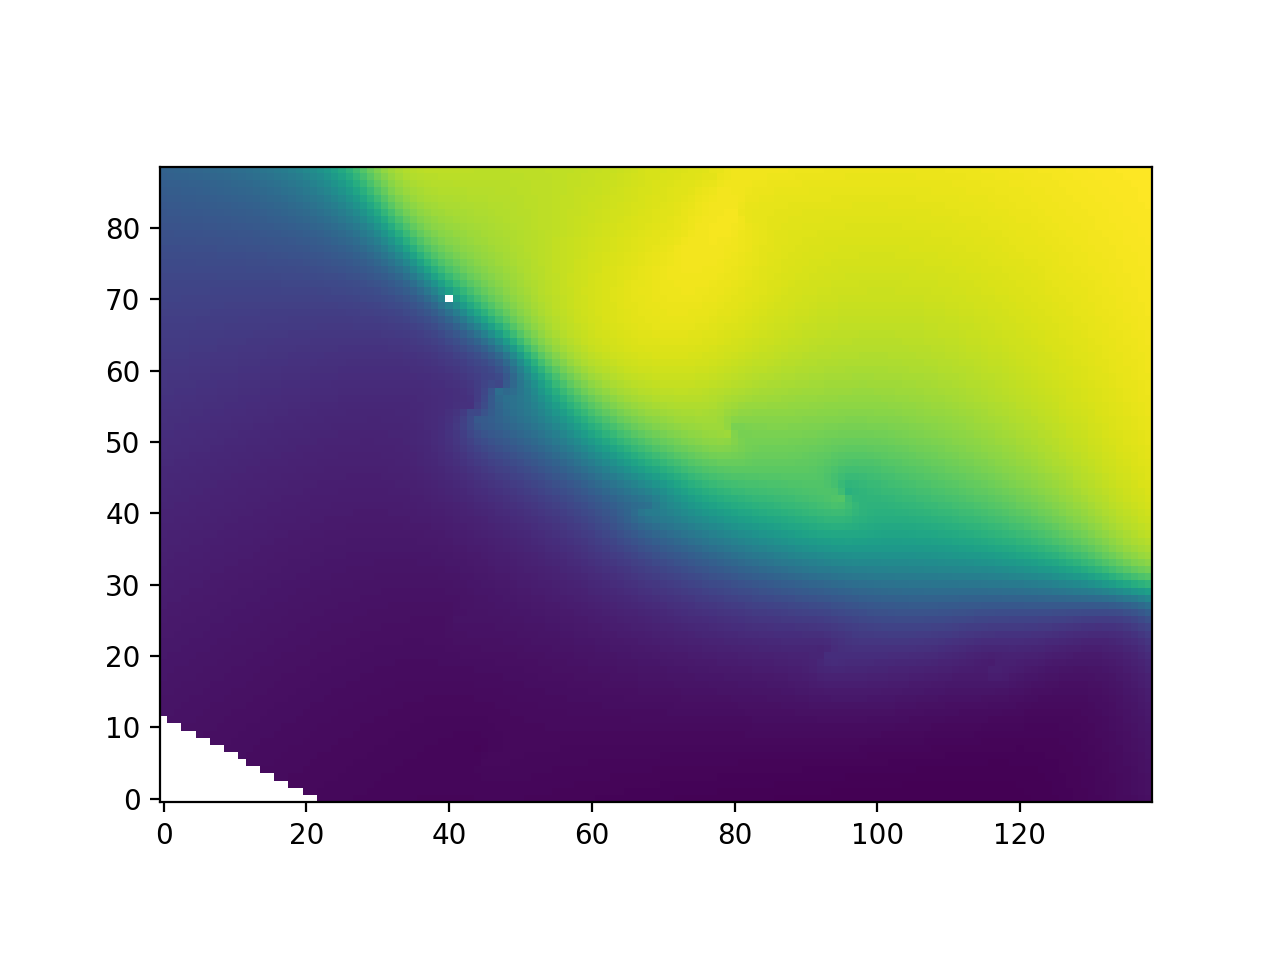

In [26]:
model.r_t = 5
model.pa = 190
dummy_gradient = model.make_model()

plt.figure()
plt.imshow(dummy_gradient,origin='lower')

The data is now also available in model.data and it can be directly showed with model.plot()

<IPython.core.display.Javascript object>


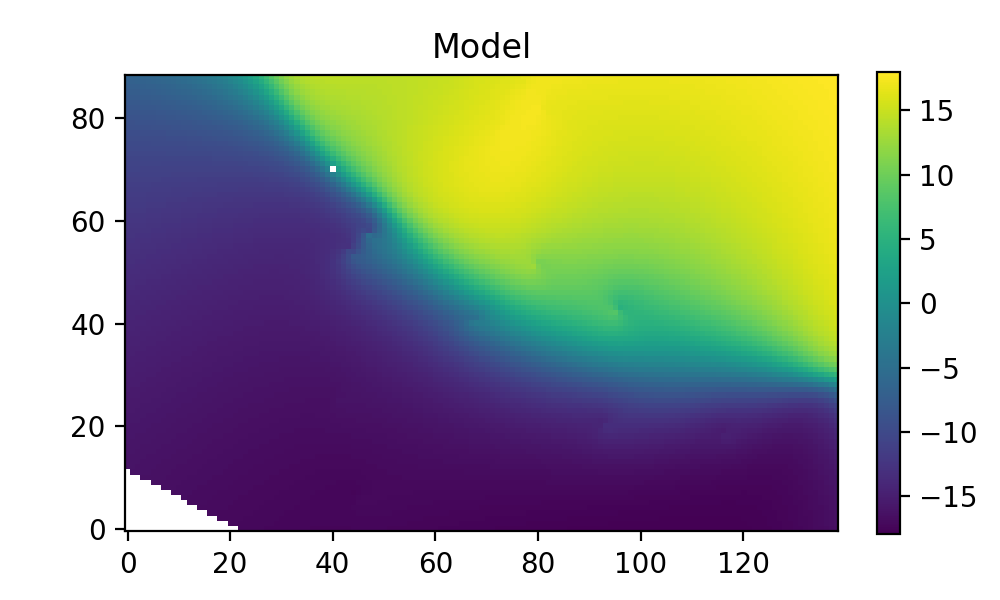

In [27]:
model.data
model.plot()

## Fitting

Now we will try to fit the model to the data. We use the __[emcee](http://dfm.io/emcee/current/ )__ sampler to make this.

A couple of things to notice:

We assume uniform priors for all parameters (maybe not the smartest, but maybe the safest).

We are maximising the following (log)-probability function:
    
$$ln(probability) = ln(priors) + ln(likelihood)$$
        
   with
   
$$ln(likelihood) = -\frac{1}{2} \big( \frac{(data-model)^2}{uncertainty^2} + ln(2\, \pi\, uncertainty^2)\big)$$
   
       

We need both the model and the observation objects we made before, but we also have to 'tell' the fitter which parameters are going to be fit and how much they are allowed to vary.

We do this using a nested dictionary, in the form:

       {parameter_name1:{'value':X, 'min':Y, 'max':Z},
        parameter_name2:{'value':A, 'min':B, 'max':C},
        ...
        }

You can build your own, or use the *make_input_parameters* auxiliary function to do this for you.

**Note:** the parameter names have to be exactly the names of the parameters of the model you're using. You can check this using model.model_parameters().

In [65]:
# We can access the all the possible parameter names to put in 'name' with:
#parameter_names = model.model_parameters()
input_par = make_input_parameters(name    = ('cx', 'cy',  'q', 'pa', 'v_t', 'r_t'),
                                 value   = (  24,   70,  0.7,   140,   200,  4.0),
                                 minimum = (  22,   68,  0.5,    90,    50,  1.0),
                                 maximum = (  26,   72,  0.99,  190,   900,  7.0))

print(input_par)

{'q': {'max': 0.99, 'value': 0.7, 'min': 0.5}, 'v_t': {'max': 900, 'value': 200, 'min': 50}, 'cy': {'max': 72, 'value': 70, 'min': 68}, 'pa': {'max': 190, 'value': 140, 'min': 90}, 'cx': {'max': 26, 'value': 24, 'min': 22}, 'r_t': {'max': 7.0, 'value': 4.0, 'min': 1.0}}


In [66]:
out = fit_model(obs,model,input_par,'a370_arctang_vel',nsteps=2500,nwalkers=24)

Using 24 walkers and fitting ['q', 'v_t', 'cy', 'pa', 'cx', 'r_t']:
MCMCing for 2500 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 25.6682 minutes


## Check fit

In [3]:
results = Output('a370_arctang_vel')

<IPython.core.display.Javascript object>


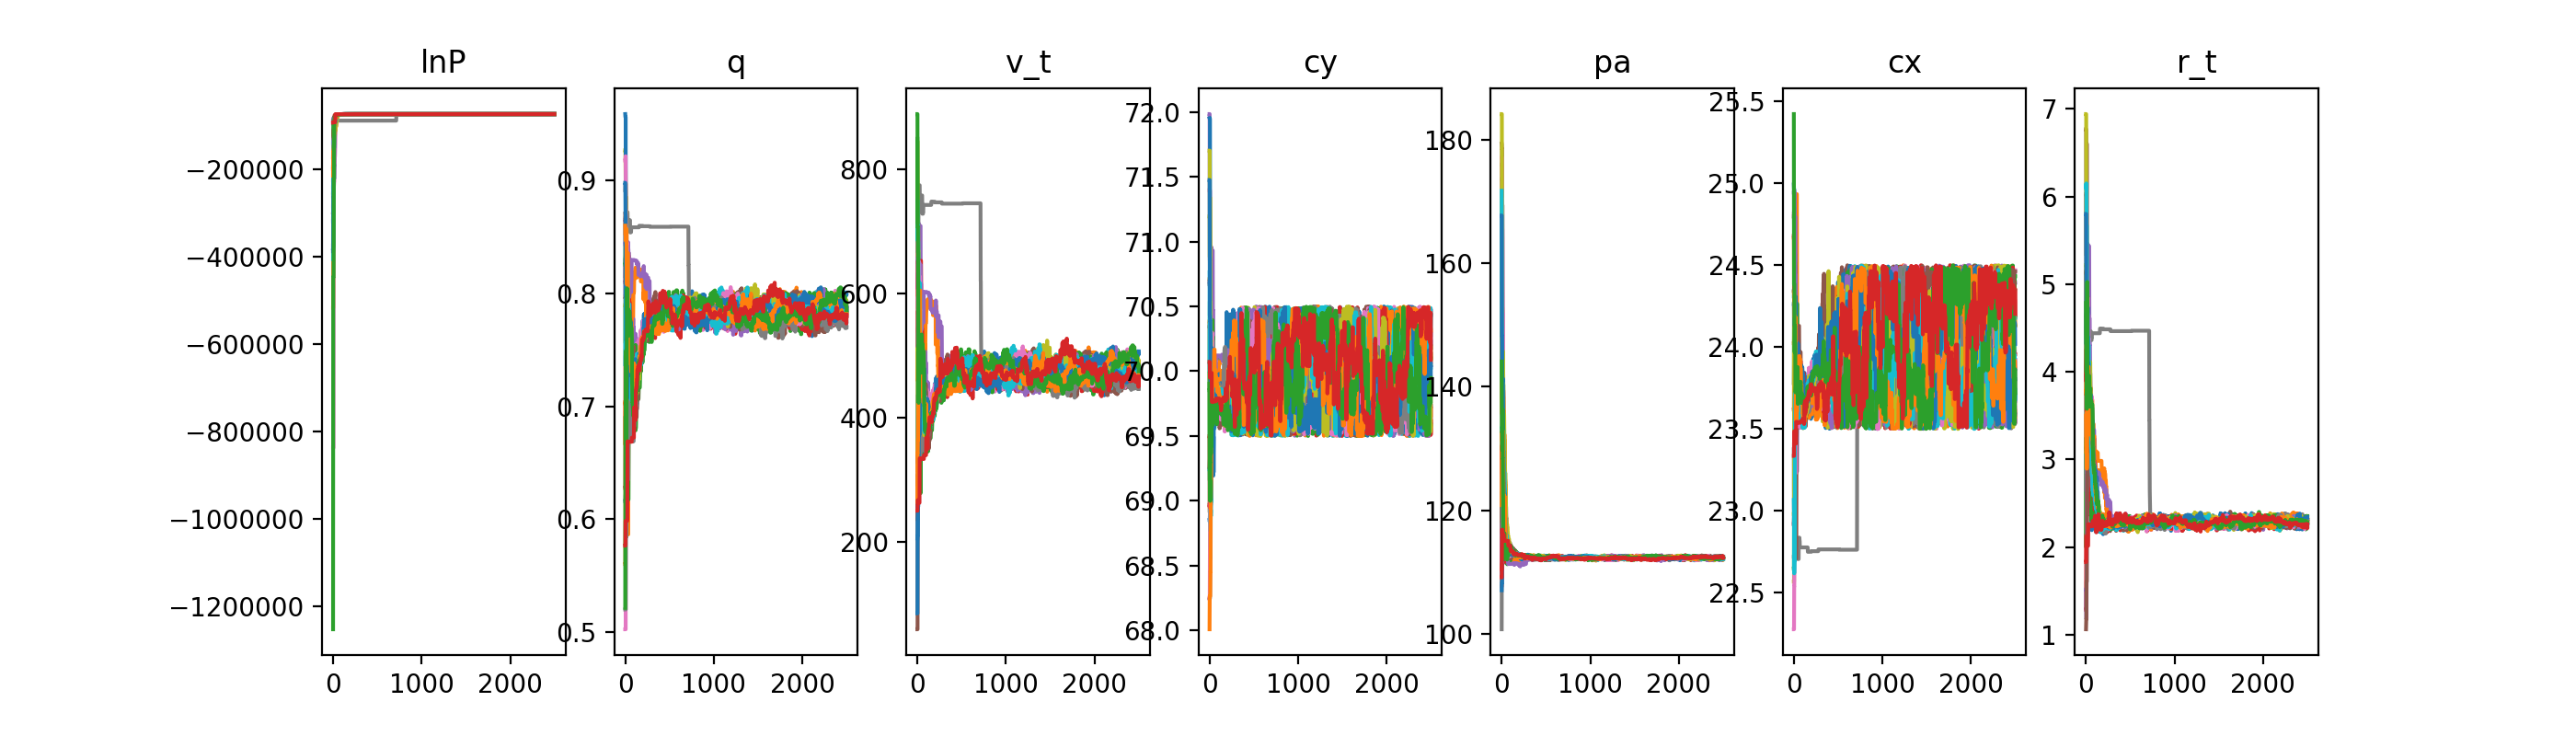

In [4]:
results.check_convergence()

<IPython.core.display.Javascript object>


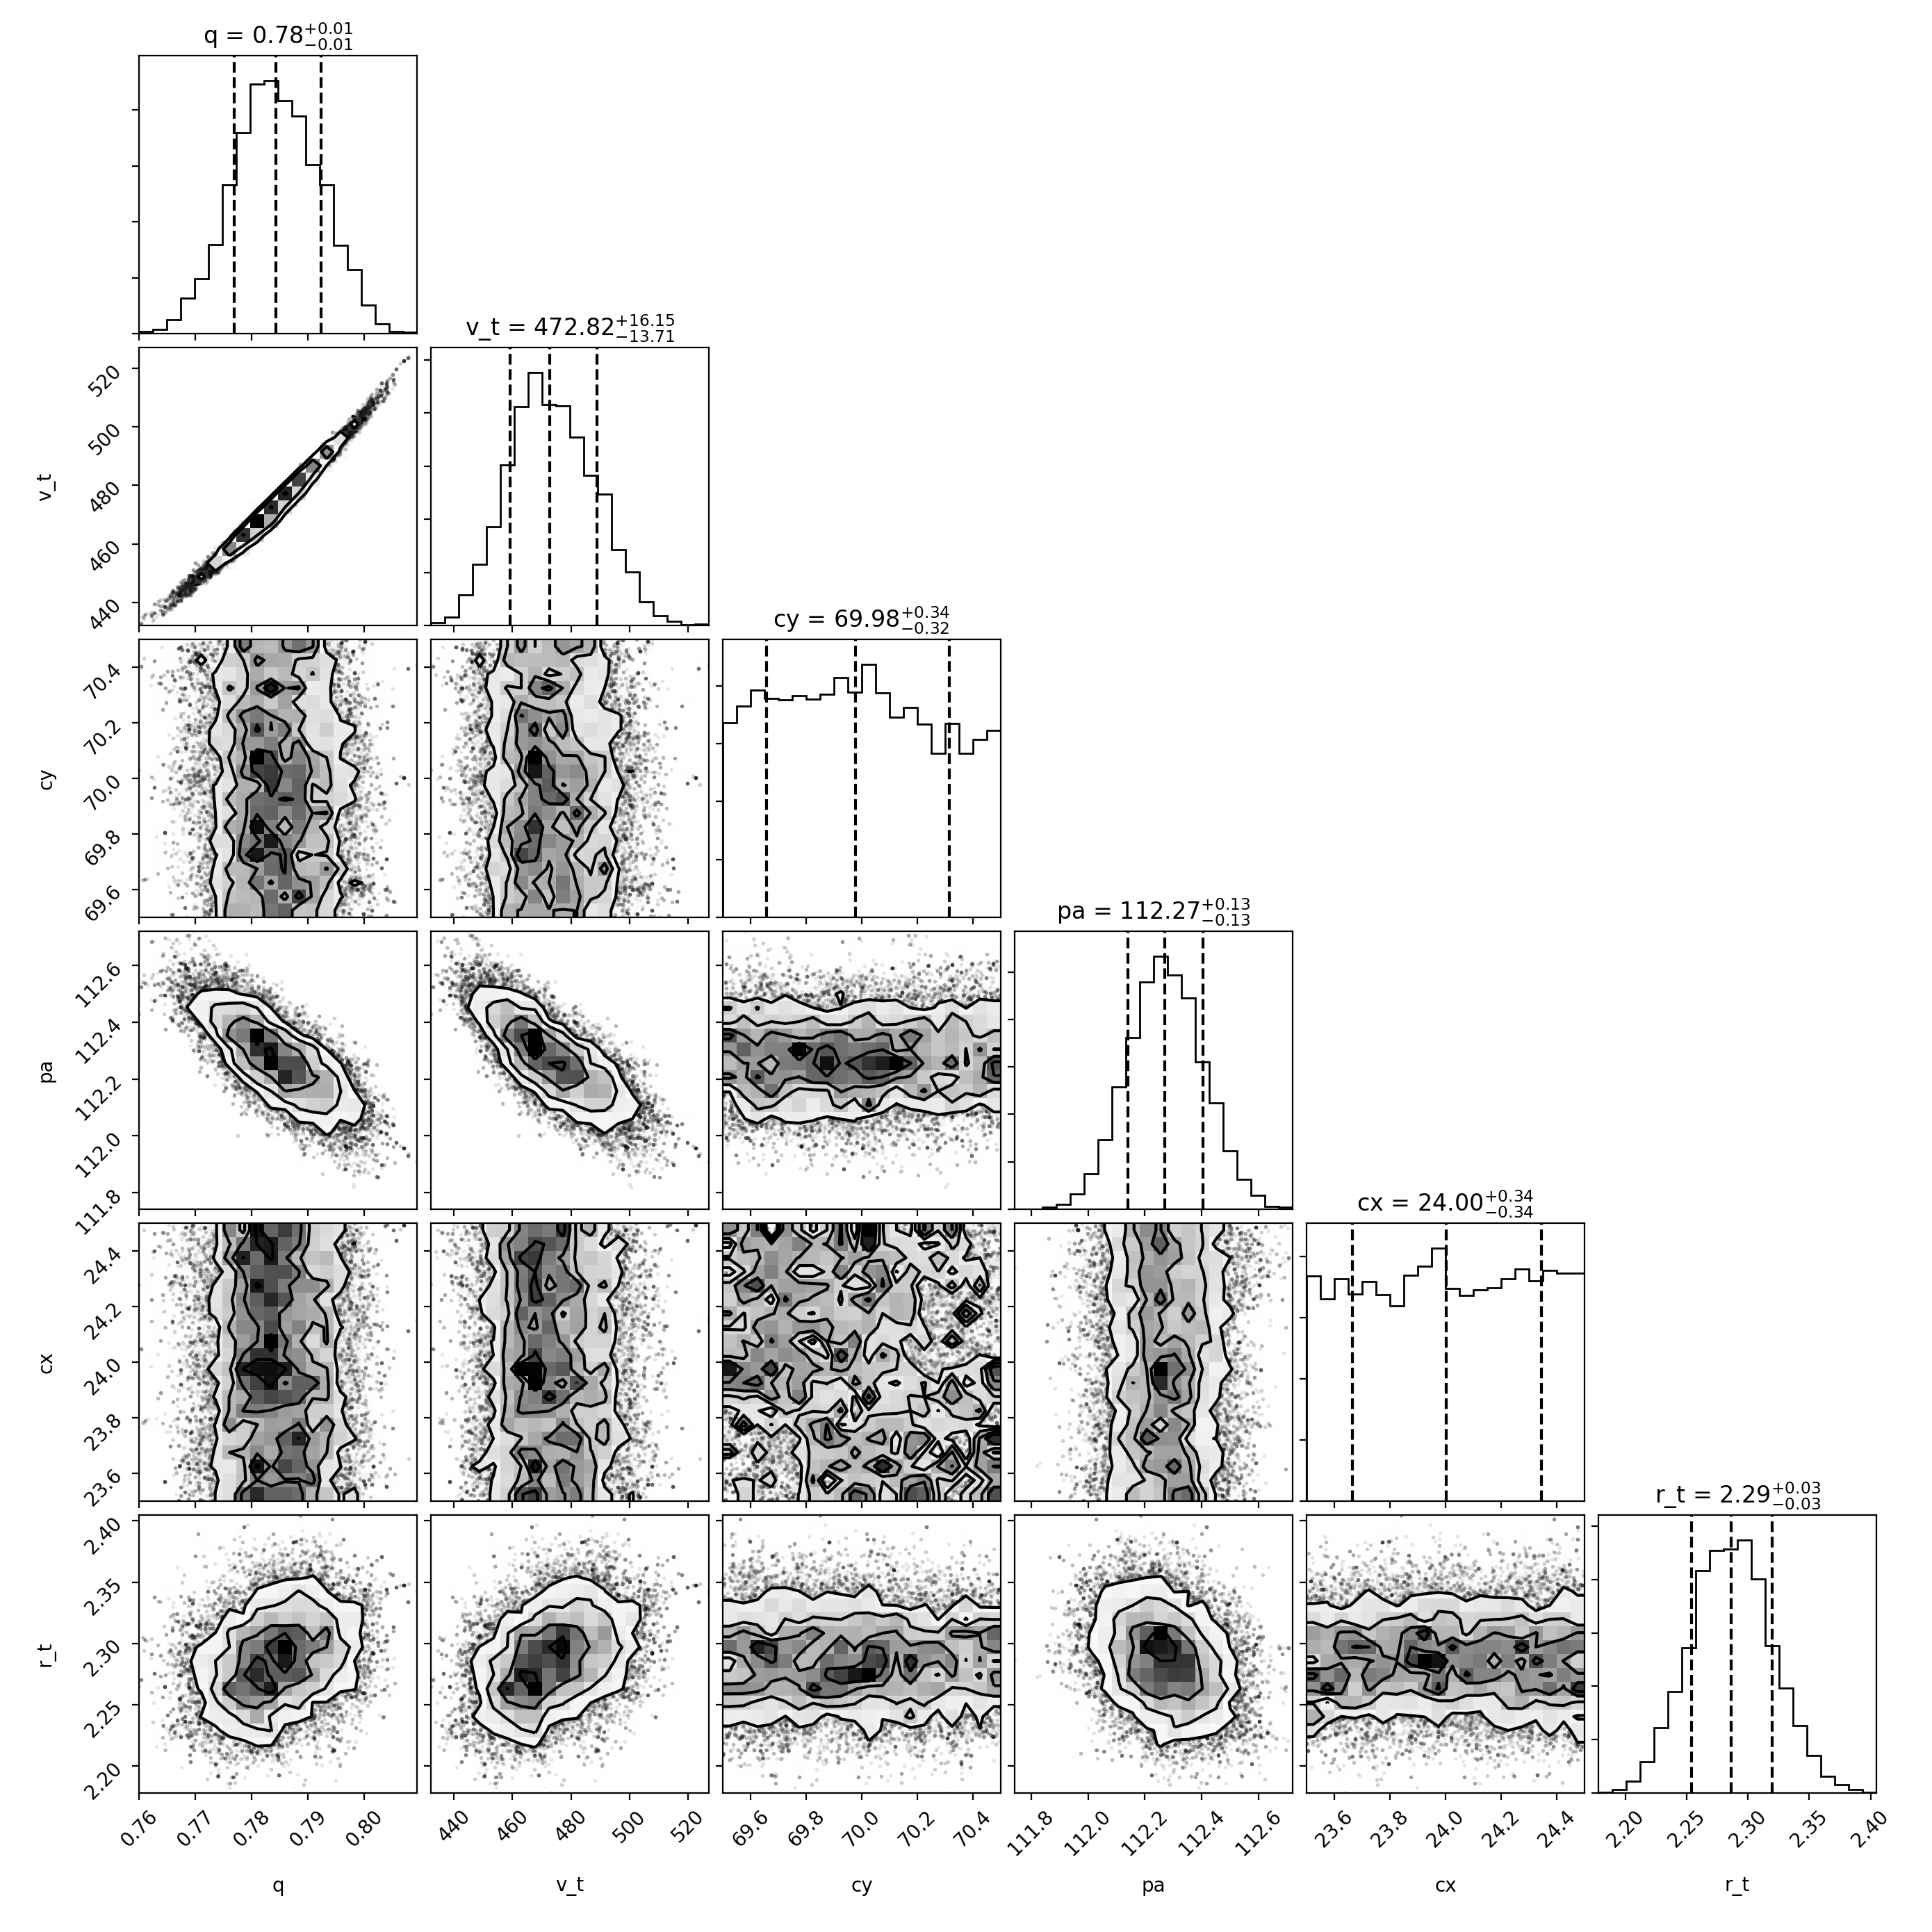

In [5]:
results.make_cornerplot(start=1000)

In [6]:
best_param = results.best_parameters(start=1000)

q 0.7842$^{+0.0081}_{-0.0073}$
v_t 472.8177$^{+16.1484}_{-13.7074}$
cy 69.9764$^{+0.3385}_{-0.3184}$
pa 112.2708$^{+0.1334}_{-0.1300}$
cx 24.0016$^{+0.3430}_{-0.3371}$
r_t 2.2861$^{+0.0337}_{-0.0322}$


Using this dictiorary, we can produce the 'best' model of this fit.

(Or you can directly modify the model's parameters)

<IPython.core.display.Javascript object>


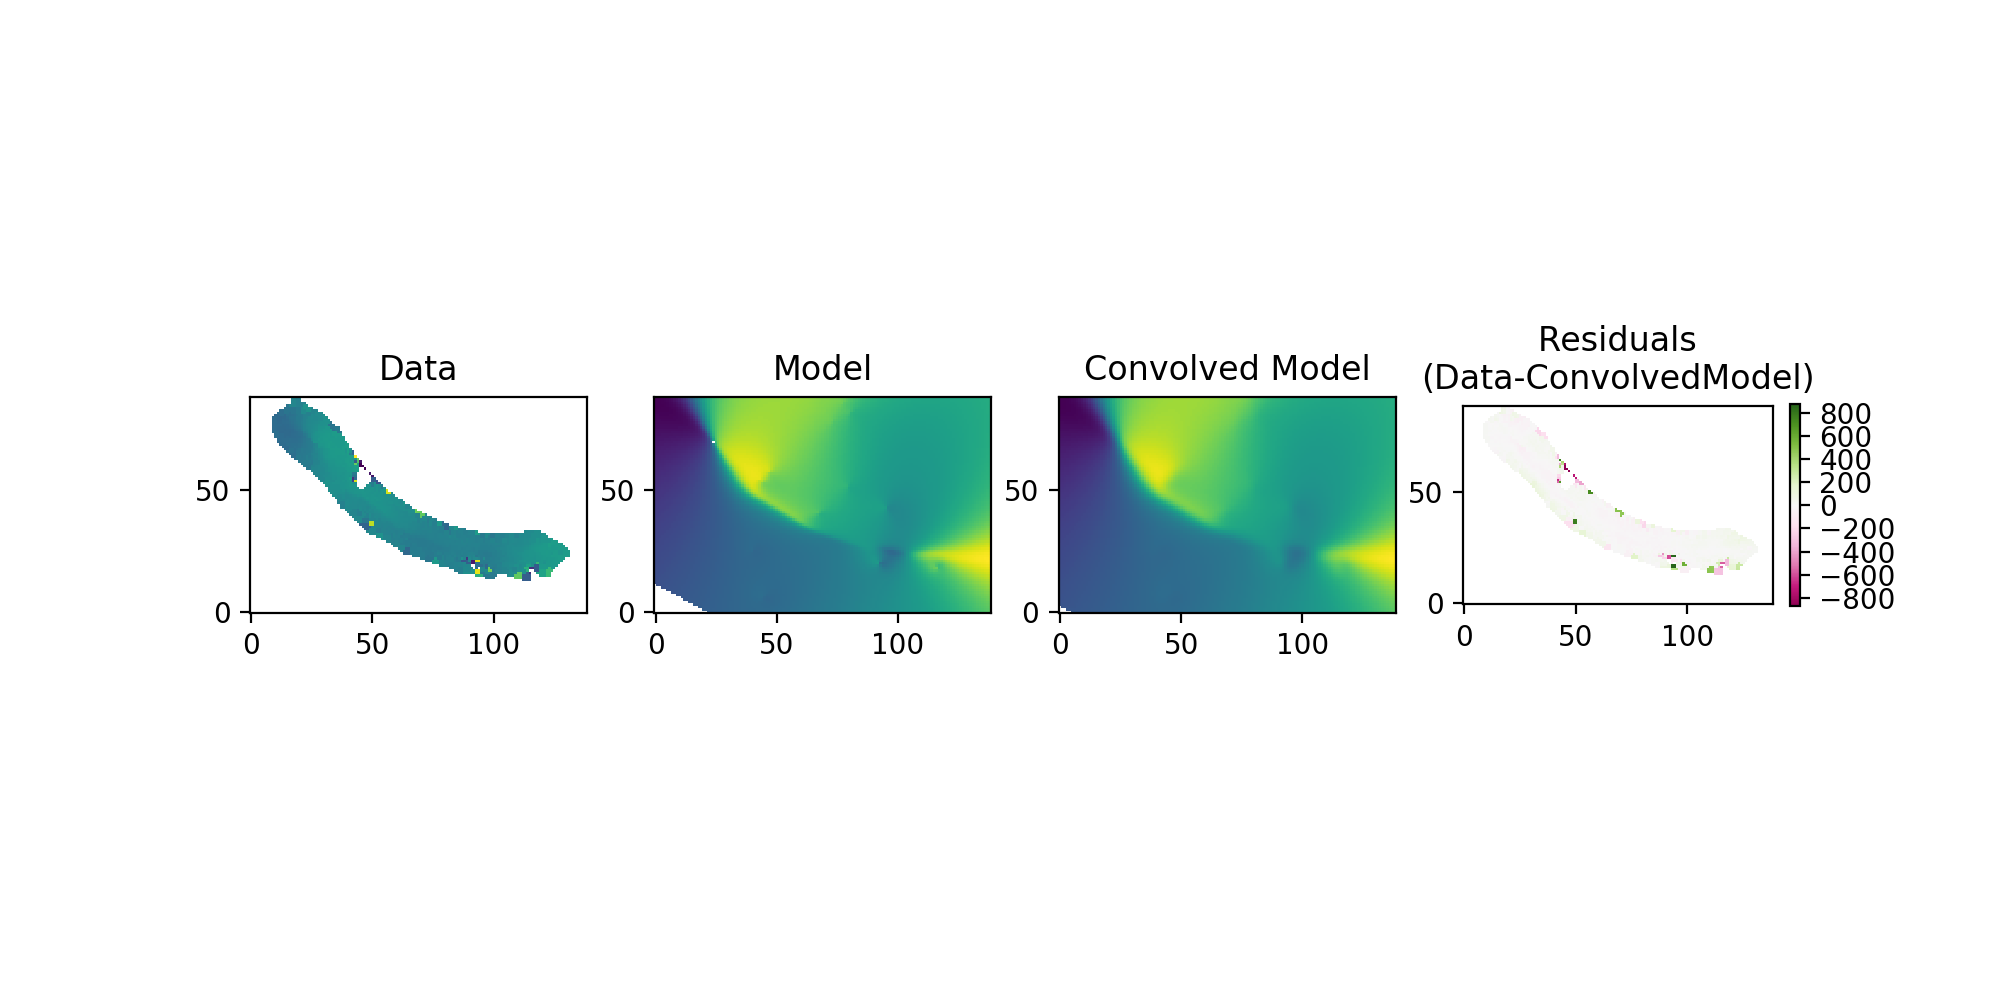

In [7]:
best_model, residuals = results.plot_solution(best_param)

Plotting it with nicer colours...

<IPython.core.display.Javascript object>


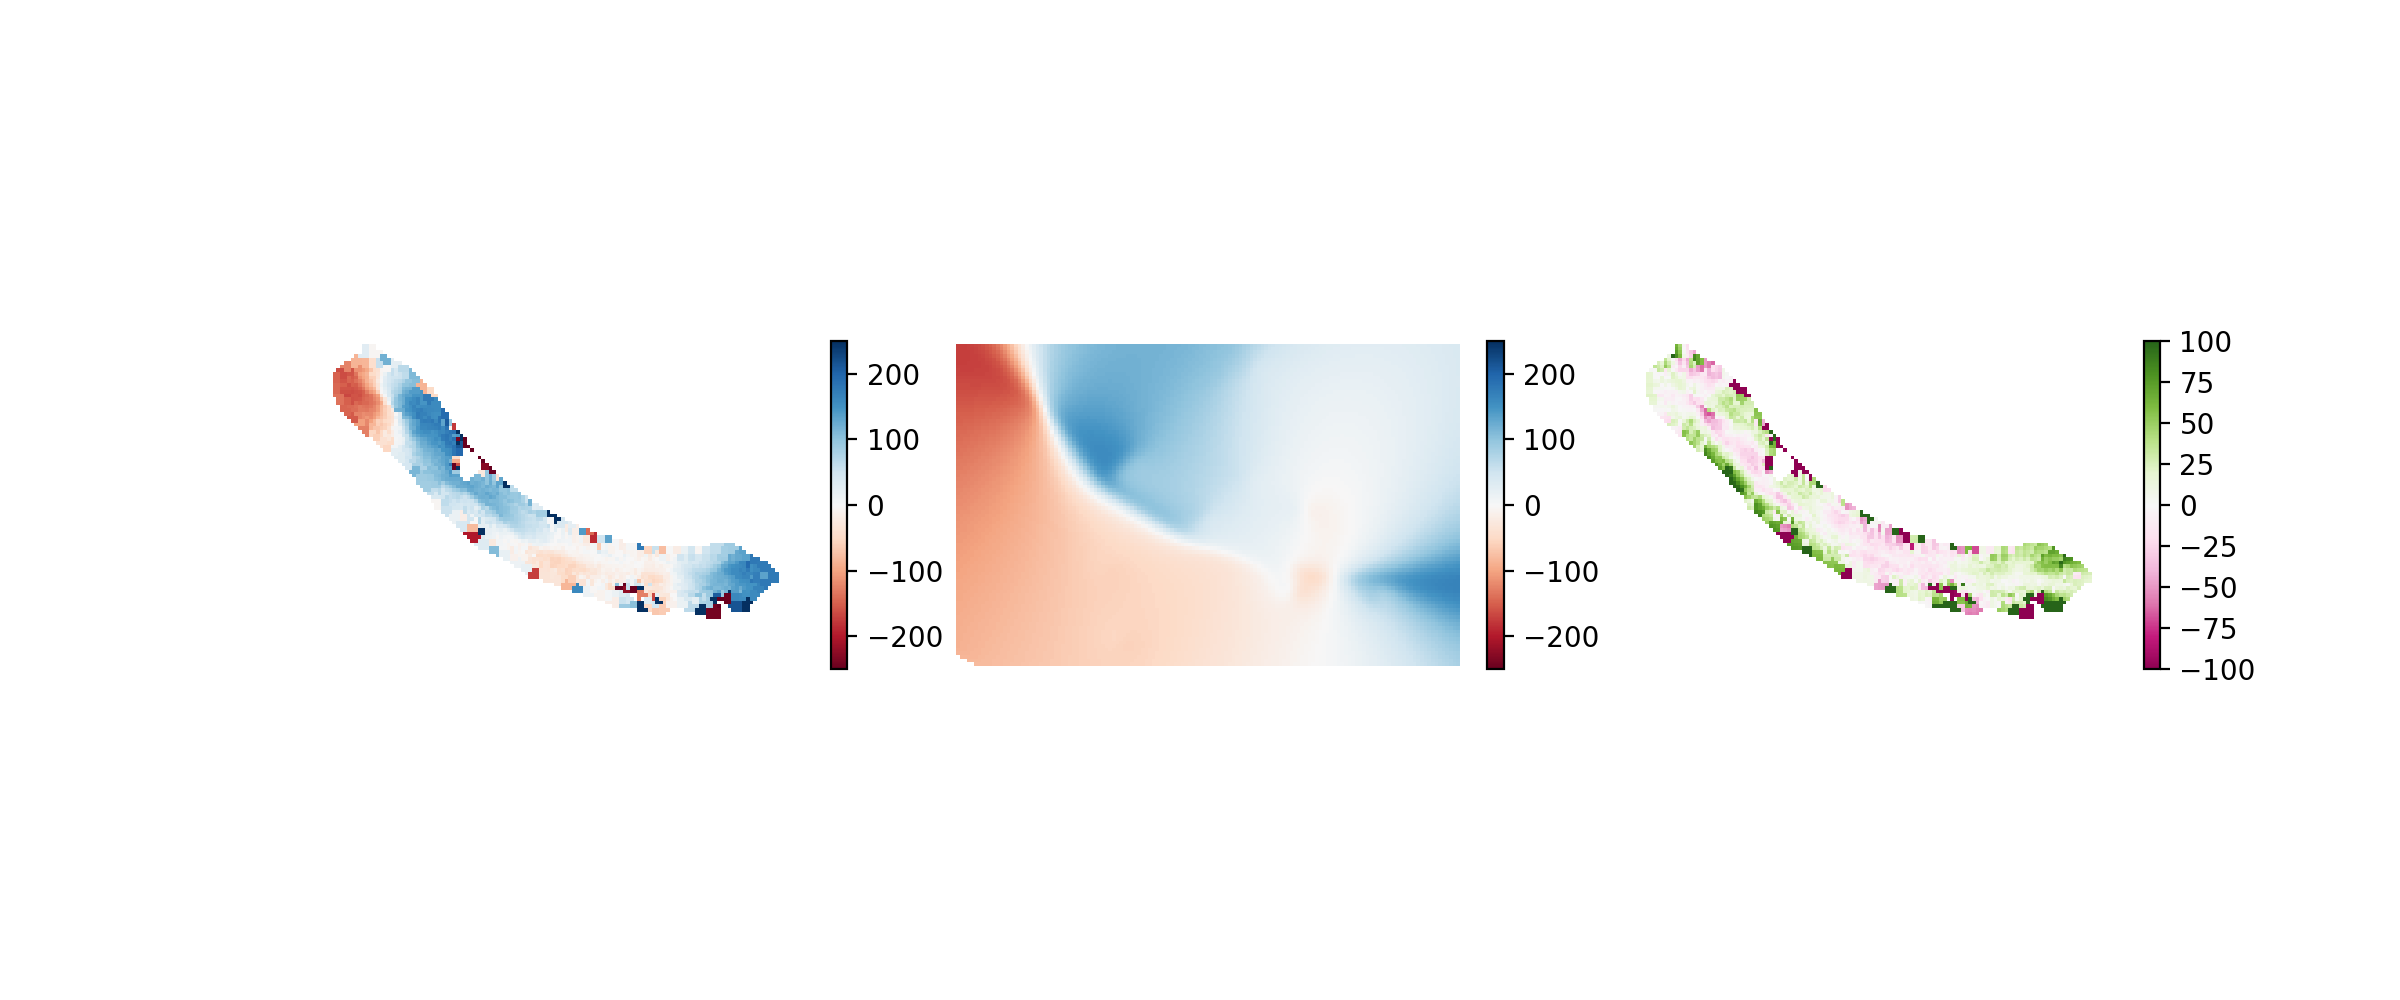

In [11]:
fig, ax = plt.subplots(1,3,figsize=(12,5))

cax = ax[0].imshow(obs.data,origin='lower',cmap='RdBu',vmax=250,vmin=-250)
plt.colorbar(cax,ax=ax[0],fraction=0.03)

convolved_model = best_model.convolve_with_seeing(obs.seeing/2.355)
cax = ax[1].imshow(convolved_model,origin='lower',cmap='RdBu',vmax=250,vmin=-250)
plt.colorbar(cax,ax=ax[1],fraction=0.03)

cax = ax[2].imshow(residuals,origin='lower',cmap='PiYG',vmax=100,vmin=-100)
plt.colorbar(cax,ax=ax[2],fraction=0.03)

dummy = [x.axis('off') for x in ax]

Some basic goodness of fit metrics can also be calculated:

In [12]:
chi2_dof = results.goodness_of_fit(best_param)

Chi2: 139208.61
Chi2/dof: 1677.21
Loglikelihood: -74359
BIC: 148745


## Fitting another velocity model

We have included 4 kinematic models in FRApy (see Epinat for details):
    
    * Arctangent (Puech 2008)
    * Flat
    * Expenential
    * Isothermal sphere
    
    
    TO BE COMPLETED